# Electrical Thermal Response Test (E-TRT) : Field Application

This code takes example on the notebook `ETRT_synthetic_example.ipynb` to perform a joint inversion of electrical resistivity and temperature data acquired during an experimental E-TRT in Varennes, Canada, from October 8th to November 4th 2024. 

This notebook contains the following sections:

1. Experimental data
2. Simpeg modelling
2. Inversion
3. Confidence intervals of the recovered parameters
4. Grid Search of the cost function

In [1]:
import numpy as np
import pandas as pd
import re
import os
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

In [2]:
plt.rcParams.update({'font.size': 9,'axes.labelsize': 8, 'xtick.labelsize': 8,'ytick.labelsize': 8,'legend.fontsize': 8,'figure.titlesize': 9,'lines.markersize': 8,})

# 1. Experimental data

The E-TRT was performed on a standing column well and included a 48-hour recirculation phase, followed by 256 hours of heating. The E-TRT data was compiled, filtered and visualized in the notebook `ETRT_Varennes_data_processing.ipynb`, and the data used in this inversion is stored in the folder `02-Varennes_data/01-Field_data/`.

In [3]:
dir_data = '../data/02-Varennes_data/01-Field_data/'

## Import data

First we define the geometry of the SCW.

In [4]:
L = 208     # effective length (m)
rBH = 0.165 / 2     # borehole radius (m)

Then we calculate the average unit heating power during the heating phase.

In [5]:
Q = np.load(os.path.join(dir_data, 'Q_heating.npy'))
q = np.average(Q) / L

print('The average unit heat flux is :', np.round(q,2), 'W/m')

The average unit heat flux is : 115.57 W/m


Now we import the E-TRT related data.

First the distributed temperature sensing (DTS) data at depth of the cable is imported. The initial temperature $T_0$ is defined as the average temperature at the recirculation phase, and the temperature measurement error is from the calibration, described in `ETRT_Varennes_data.ipynb`.

In [6]:
data_dts = pd.read_csv(os.path.join(dir_data,'data_DTS_heating.csv'))

T0 = 11.5  
T_fiber = np.array(data_dts['temperature (degC)'])
t_fiber = np.array(data_dts['time (s)'])

sigma_trt = 0.26  # degC

Now the laboratory calibration data of water samples and the LTC probe data are imported. The initial water electrical conductivity is obtained in `ETRT_Varennes_data.ipynb`.

In [7]:
lab_cal =  pd.read_csv(os.path.join(dir_data,'data_LTC_lab_measurements.csv'))
data_ltc = pd.read_csv(os.path.join(dir_data,'data_LTC_heating.csv'))
sigma_w0 = 0.53 # S/m

The black temperature line is the temperature measured at the depth of the cable by the DTS system. We obtained a measurement error based on the calibration data.

The electrical resistivity data was acquired on a multi-electrode cable, where the instrumented section was installed in the borehole at a depth of 150-157.75 m, using a pole-pole geometry. Each electrode spacing was average supposing a homogeneous medium. The temperature data is the averaged value measured by distributed temperature sensing at the depth of the cable. The ERT data is a csv containing the average apparent resistivity change at each time and electrode spacing during the E-TRT. See `ETRT_Varennes_data.ipynb` for more details.

In [8]:
field_data = pd.read_csv(os.path.join(dir_data, 'data_ERT_heating.csv'))
print(field_data.head())
zrec = np.unique(field_data['spacing (m)'])
print('Electrode spacings (m):', zrec)

sigma_ert = 0.092 # ERT measurement error (Ohm.m)
sigma_ref = 1/15 # reference apparent resistivity (Ohm.m)

   time (s)             datetime  spacing (m)  avg Rho-a (Ohm-m)  \
0         0  2024-10-17 16:30:00         0.25          15.471400   
1         0  2024-10-17 16:30:00         0.50          17.544790   
2         0  2024-10-17 16:30:00         0.75          17.115210   
3         0  2024-10-17 16:30:00         1.00          15.991590   
4         0  2024-10-17 16:30:00         1.25          15.259789   

   std Rho-a (Ohm-m)  avg dRho-a (Ohm-m)  std dRho-a (Ohm-m)  rel avg (%)  \
0           0.733359                 0.0                 0.0          0.0   
1           0.855139                 0.0                 0.0          0.0   
2           0.623671                 0.0                 0.0          0.0   
3           0.704630                 0.0                 0.0          0.0   
4           0.716825                 0.0                 0.0          0.0   

   rel std (%)  residual  rel residual (%)  
0          0.0  0.656400               0.0  
1          0.0  0.733966              

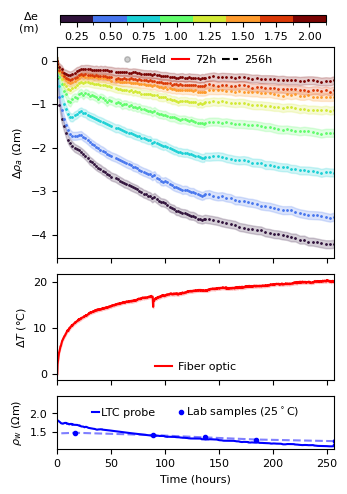

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(9/2.54, 13/2.54), sharex=True, height_ratios=[4, 2, 1])

Ndata = [11, 10, 10, 10, 9, 9, 9, 8]

dtime = np.unique(field_data['time (s)'])/3600
spacing = np.unique(field_data['spacing (m)'])

colors = plt.cm.turbo(np.linspace(0, 1, len(spacing)))
for s, dz in enumerate(spacing):
    subset = field_data[field_data['spacing (m)'] == dz]
    subset = subset.sort_values(by='time (s)')[:100]
    
    ax[0].plot(dtime, subset['avg dRho-a (Ohm-m)'], 'o', color=colors[s], markersize=1)
    ax[0].fill_between(dtime,subset['avg dRho-a (Ohm-m)'] - sigma_ert,subset['avg dRho-a (Ohm-m)'] + sigma_ert,color=colors[s], alpha=0.2)


ax[1].plot(t_fiber/3600, T_fiber - T0, 'red', label='Fiber optic')
ax[1].fill_between(t_fiber/3600, (T_fiber - T0 - sigma_trt), (T_fiber - T0 + sigma_trt), color='red', alpha=0.2)

ax[0].set_ylabel(r'$\Delta \rho_a$ ($\Omega$m)')
ax[1].set_ylabel(r'$\Delta T$ (°C)')

ax[2].plot(data_ltc['time (s)']/3600, 1 / data_ltc['sigma_w (S/m)'], label='LTC probe', color='blue')
ax[2].plot(lab_cal['time (s)']/3600, 1 / lab_cal['sigma_w (S/m)'], 'o', label=r'Lab samples (25$^\circ$C)', color='blue', ms=3)
ax[2].plot(lab_cal['time (s)']/3600, 1 / lab_cal['sigma_w (S/m)'], '--', color='blue', alpha=0.5)
#ax[2].text((lab_cal['time (s)'][2]-0.1)*24, 1 / lab_cal['sigma_w (S/m)'][2] * 10 - 0.4, 'A')
#ax[2].text((lab_cal['time (s)'][6]-.4)*24, 1 / lab_cal['sigma_w (S/m)'][6] * 10 + 0.2, 'B')
ax[2].set_ylabel(r'$\rho_w$ ($\Omega$m)')
ax[2].set_xlabel('Time (hours)')
ax[2].legend(loc='upper center', fontsize=8, 
             frameon=False, ncol=2, handlelength=0.7, handletextpad=0.1, labelspacing=0.1)

for a in ax:
    a.set_xlim(0, 256.7)
    a.tick_params(axis='both', which='major')
    
fitted_handle, = ax[0].plot([], [], 'o', color='black', label='Field', ms=4, alpha=0.2)
field_handle, = ax[0].plot([], [], '-', color='red', label='72h')      
field_handle, = ax[0].plot([], [], '--', color='black', label='256h')

ax[0].legend(fontsize=8, ncol=3, loc='upper center', frameon=False, handlelength=1.5, handletextpad=0.5, borderpad=0.2, columnspacing=0.5)
ax[1].legend(fontsize=8, ncol=3, loc='lower center', frameon=False, handlelength=1.5, handletextpad=0.5, borderpad=0.2, columnspacing=0.5)

plt.tight_layout()

fig.subplots_adjust(top=0.88)

cmap = mcolors.ListedColormap(colors)
bounds = np.append(spacing - 0.125, spacing[-1] + 0.125)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.18, 0.93, 0.75, 0.012])
cb = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', ticks=spacing)
fig.text(0.12, 0.93, '$\\Delta$e \n(m)', va='center', ha='right', fontsize=8, rotation=0, color='black')

plt.show()

The first 24 hours of ERT data will be removed to exclude the influence of thermochemical reactions.

## Prepare data for inversion

As in the synthetic case, we remove the first 12 hours of TRT data to avoid short-term modelling errors

In [10]:
times_trt = np.array(data_dts['time (s)'])[72:]
T_trt = np.array(data_dts['temperature (degC)'])[72:]

Data from the LTC probe is selected to match the ERT timesteps and a dataframe is created with both informations.

In [11]:
sigma_w = np.interp(np.unique(field_data['time (s)']), data_ltc['time (s)'], data_ltc['sigma_w (S/m)'])
sigma_w = np.array(sigma_w)

ERT_input = pd.DataFrame({'time': np.unique(field_data['time (s)']), 'sigmaw': sigma_w})

We keep ERT data every 4 hours after 24 hours to have the same time steps during the whole survey.

In [12]:
# here we equalize all the time steps
ERT_keep = pd.concat([ERT_input.iloc[13:][::2][:29], ERT_input.iloc[13:][57:]], ignore_index=True)
ERT_keep = pd.concat([ERT_input.iloc[13:][::2][:12], ERT_input.iloc[[36]], ERT_input.iloc[13:][::2][12:29], ERT_input.iloc[13:][57:]], ignore_index=True)

print('all ERT times :', np.round(ERT_input['time'].values/3600, 1), 'hours')
print('kept ERT times :', np.round(ERT_keep['time'].values/3600, 1), 'hours')

all ERT times : [  0.    0.3   2.3   4.3   6.3   8.3  10.3  12.3  14.3  16.3  18.3  20.3
  22.3  24.3  26.3  28.3  30.3  32.3  34.3  36.3  38.3  40.3  42.3  44.3
  46.3  48.3  50.3  54.3  56.3  58.3  60.3  62.3  64.3  66.3  68.3  70.3
  72.3  74.3  76.3  78.3  80.3  82.3  84.3  86.3  88.3  90.3  92.3  94.3
  96.3  98.3 100.3 102.3 104.3 106.3 108.3 110.3 112.3 114.3 116.3 118.3
 120.3 122.3 124.3 126.3 128.3 130.3 132.3 134.3 136.3 137.  141.  145.
 149.  153.  157.  161.  165.  169.  173.  177.  181.  185.  189.  193.
 197.  201.  205.  209.  213.  217.  221.  225.  229.  233.  237.  241.
 245.  249.  253.  256.7] hours
kept ERT times : [ 24.3  28.3  32.3  36.3  40.3  44.3  48.3  54.3  58.3  62.3  66.3  70.3
  72.3  74.3  78.3  82.3  86.3  90.3  94.3  98.3 102.3 106.3 110.3 114.3
 118.3 122.3 126.3 130.3 134.3 137.  141.  145.  149.  153.  157.  161.
 165.  169.  173.  177.  181.  185.  189.  193.  197.  201.  205.  209.
 213.  217.  221.  225.  229.  233.  237.  241.  245.  249.  253

## Experimental variogram

The inversion normalizes the two datasets by their measurement error.

Instead of assuming uncorrelated error, we estimate the experimental variogram of the temperature residuals to build a covariance matrix with correlated residuals. We follow the formulation of :
- Pasquier,P.,Marcotte,D.,2020. Robust identification of volumetric heat capacity and analysis of thermal response tests by bayesian inference with correlated residuals. Applied Energy 261, 114394. doi: 10.1016/j.apenergy.2019.114394.

The exponential covariance model is given by
$$
C(h) = \sigma^2 \exp\left(-\frac{h}{a}\right),
$$
where $h$ is the time lag, $a$ is the correlation length and $\sigma^2$ is the sill of the variogram. $a$ and $\sigma^2$ are estimated from the experimental variogram of the residuals after a first inversion assuming uncorrelated residuals.

The experimental variogram is computed using the following formulation 
$$
\gamma_e(h) = \frac{1}{2N_h}\sum_{i, j;|t_i-t_j|=h}(x_i-x_j)^2
$$

In [13]:
from etrt import bayesian_inversion, CTi, get_Cdi, ICS

The inversion is first run assuming uncorrelated residuals to obtain initial residuals

In [14]:
Cdi_trt = np.diag(np.ones(len(t_fiber)) / 0.26**2)
m0 = np.r_[2.74, 2]

def fun(m):
    dt, J = ICS(rBH, t_fiber, q, m[0], m[1], rBH, getJ=True, eps=1e-5)
    J = np.delete(J, 2, axis=1)
    return dt, J

m_est, *_ = bayesian_inversion(fun, T_fiber - T0, m0, Cdi_trt, niter=15,
                               step=0.8, doprint=True)
dT_est, J = fun(m_est)
resT =  T_fiber - T0 - dT_est
print('k_s =', m_est[0], 'W/mK', 'c_s =',  m_est[0], 'm2K/W', 'RMSE =', np.round(np.sqrt(np.mean((resT)**2)), 3))

iter 0: cost = 1.864e+03 (data = 1.864e+03, model = 0.000e+00) m = [2.55618627 2.63065314]
iter 1: cost = 1.521e+03 (data = 1.521e+03, model = 0.000e+00) m = [2.52986672 2.83590657]
iter 2: cost = 1.012e+03 (data = 1.012e+03, model = 0.000e+00) m = [2.52554579 2.88145692]
iter 3: cost = 9.781e+02 (data = 9.781e+02, model = 0.000e+00) m = [2.52490562 2.88992313]
iter 4: cost = 9.766e+02 (data = 9.766e+02, model = 0.000e+00) m = [2.52481997 2.89143175]
iter 5: cost = 9.765e+02 (data = 9.765e+02, model = 0.000e+00) m = [2.5248103  2.89169896]
iter 6: cost = 9.765e+02 (data = 9.765e+02, model = 0.000e+00) m = [2.52480966 2.89174637]
iter 7: cost = 9.765e+02 (data = 9.765e+02, model = 0.000e+00) m = [2.52480975 2.89175479]
iter 8: cost = 9.765e+02 (data = 9.765e+02, model = 0.000e+00) m = [2.52480981 2.8917563 ]
iter 9: cost = 9.765e+02 (data = 9.765e+02, model = 0.000e+00) m = [2.52480983 2.89175656]
iter 10: cost = 9.765e+02 (data = 9.765e+02, model = 0.000e+00) m = [2.52480983 2.89175662

In [15]:
# Exclude power outage
t = np.concatenate([t_fiber[:500], t_fiber[600:]]) 
resT = np.concatenate([resT[:500], resT[600:]])

# Remove first 12 hours
resT = resT[72:]
t = t[72:]

Then we calculate the experimental variogram from the residuals

In [16]:
# Calculate experimental variogram
n_lags = 50
max_lag = (t.max() - t.min()) / 2
lag_bins = np.linspace(0, max_lag, n_lags + 1)
lags = (lag_bins[1:] + lag_bins[:-1]) / 2
    
variogram = np.zeros(n_lags)
count = np.zeros(n_lags)
    
# Compute variogram
for i in range(len(t)):
    for j in range(i+1, len(t)):
        # Calculate time difference (lag)
        h = abs(t[j] - t[i])
            
        if h <= max_lag:
            # Find the bin index
            bin_idx = np.searchsorted(lag_bins, h) - 1
            if bin_idx < n_lags:
                # Add squared difference to variogram
                variogram[bin_idx] += (resT[j] - resT[i])**2
                count[bin_idx] += 1
    
valid_bins = count > 0
variogram[valid_bins] /= (2 * count[valid_bins])

We plot the resulting variogram and fit the exponential variogram model

In [17]:
a = 7 # hours
sill = 0.013
exp_model = sill * (1 - np.exp(-lags /3600 / a))

Text(0, 0.5, 'Variogram')

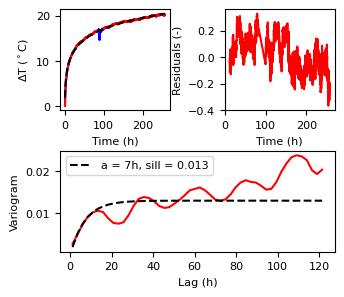

In [18]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(9/2.54, 8/2.54))  
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])
gs.update(hspace=0.4, wspace=0.5)


ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, :])

ax0.plot(t_fiber/3600, T_fiber-T0, 'b-')
ax0.plot(t_fiber[:500]/3600, T_fiber[:500]-T0, 'r-')
ax0.plot(t_fiber[600:]/3600, T_fiber[600:]-T0, 'r-')
ax0.plot(t_fiber/3600, dT_est, 'k--')

ax1.plot(t/3600, resT, 'r-')

ax2.plot(lags/3600, variogram, 'r-')
ax2.plot(lags/3600, exp_model, 'k--', label='a = 7h, sill = 0.013')
ax2.legend()


ax0.set_xlabel('Time (h)')
ax0.set_ylabel('$\\Delta$T ($^\\circ$C)')
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Residuals (-)')
ax2.set_xlabel('Lag (h)')
ax2.set_ylabel('Variogram')


We obtain the covariance matrix with correlation residuals with the help of the function `lib_ert.CTi`.

In [19]:
help(CTi)

Help on function CTi in module etrt.lib_etrt:

CTi(t: numpy.ndarray, a: float = 7, varT: float = 0.013)
    Covariance matrix for temperature data based on exponential covariogram
    :param t: time points (hours), shape: (nT,)
    :param a: correlation range (hours)
    :param varT: covariance value (degC^2)
    :return:  covariance matrix, shape: (nT, nT)



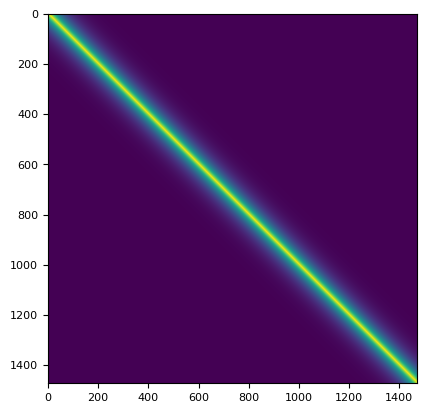

In [20]:
Cdi_trt = CTi(t_fiber[72:]/3600, a, sill)

plt.imshow(Cdi_trt)

# 2. Inversion

We run the inversion following the same procedure as in the `ETRT_synthetic_example.ipynb` notebook. We first run the inversion using the full 256 h dataset and then using a 72 h dataset. The latter is a more typical duration.

In [21]:
from etrt import bayesian_inversion, simulate_etrt, ICS, ert_setup, CTi

## TRT inversion

First we run the inversion using only the temperature data from the TRT.

In [24]:
m0 = np.r_[2.74, 4.07, 0.018]

d_T = T_trt - T0
Cdi_trt = np.linalg.inv(CTi(times_trt/3600, 7, 0.013))

def fun(m):
    dt, J = ICS(rBH, times_trt, q, m[0], m[1], rBH, getJ=True, eps=1e-5)
    J = np.delete(J, 2, axis=1)
    return dt, J

m_est_T256h, *_ = bayesian_inversion(fun, d_T, m0[:-1], Cdi_trt, niter=15,
                                     step=0.8, doprint=True)
d_est, J = fun(m_est_T256h)
chi2_est = np.sum(Cdi_trt@(d_est-d_T)**2)
Cm_trt_256h = np.linalg.inv(J.T@Cdi_trt@J)
print("est :", m_est_T256h)
print('rmse', np.round(np.sqrt(np.mean((d_est - d_T)**2)), 3), 'degC')
print('rmse (%):', np.round(np.sqrt(np.mean((d_est - d_T)**2))/np.mean(np.abs(d_T))*100, 3), '%')

iter 0: cost = 1.950e+04 (data = 1.950e+04, model = 0.000e+00) m = [2.62226483 2.46658048]
iter 1: cost = 1.260e+04 (data = 1.260e+04, model = 0.000e+00) m = [2.59513727 2.57512284]
iter 2: cost = 1.260e+04 (data = 1.260e+04, model = 0.000e+00) m = [2.5901128  2.59803085]
iter 3: cost = 1.260e+04 (data = 1.260e+04, model = 0.000e+00) m = [2.5891569 2.6025232]
iter 4: cost = 1.260e+04 (data = 1.260e+04, model = 0.000e+00) m = [2.58897193 2.60339988]
iter 5: cost = 1.260e+04 (data = 1.260e+04, model = 0.000e+00) m = [2.5889393  2.60355667]
iter 6: cost = 1.260e+04 (data = 1.260e+04, model = 0.000e+00) m = [2.58893254 2.60358913]
iter 7: cost = 1.260e+04 (data = 1.260e+04, model = 0.000e+00) m = [2.588933  2.6035879]
iter 8: cost = 1.260e+04 (data = 1.260e+04, model = 0.000e+00) m = [2.58893456 2.60358129]
iter 9: cost = 1.260e+04 (data = 1.260e+04, model = 0.000e+00) m = [2.58893345 2.60358611]
iter 10: cost = 1.260e+04 (data = 1.260e+04, model = 0.000e+00) m = [2.58893094 2.60359684]
it

Running a Bayesian inversion on the TRT data for a 72 hours survey

In [25]:
i_T72h = 365

In [26]:
d_T = T_trt[:i_T72h] - T0
t_trt = times_trt[:i_T72h]
Cdi_trt = np.linalg.inv(CTi(t_trt/3600, 7, 0.013))

def fun(m):
    dt, J = ICS(rBH, t_trt, q, m[0], m[1], rBH, getJ=True, eps=1e-5)
    J = np.delete(J, 2, axis=1)
    return dt, J

m_est_T72h, *_ = bayesian_inversion(fun, d_T, m0[:-1], Cdi_trt, niter=15,
                                    step=0.8, doprint=True)
d_est, J = fun(m_est_T72h)
chi2_est = np.sum(Cdi_trt@(d_est-d_T)**2)
Cm_trt_72h = np.linalg.inv(J.T@Cdi_trt@J)
print("est :", m_est_T72h)
print('rmse', np.round(np.sqrt(np.mean((d_est - d_T)**2)), 3), 'degC /', np.round(np.sqrt(np.mean((d_est - d_T)**2))/np.mean(np.abs(d_T))*100, 3), '%')

iter 0: cost = 3.152e+03 (data = 3.152e+03, model = 0.000e+00) m = [2.45462676 3.22003258]
iter 1: cost = 1.605e+03 (data = 1.605e+03, model = 0.000e+00) m = [2.42849013 3.21814882]
iter 2: cost = 1.597e+03 (data = 1.597e+03, model = 0.000e+00) m = [2.42363214 3.21743426]
iter 3: cost = 1.597e+03 (data = 1.597e+03, model = 0.000e+00) m = [2.42267959 3.21725495]
iter 4: cost = 1.597e+03 (data = 1.597e+03, model = 0.000e+00) m = [2.42249794 3.21718342]
iter 5: cost = 1.597e+03 (data = 1.597e+03, model = 0.000e+00) m = [2.42245838 3.21718285]
iter 6: cost = 1.597e+03 (data = 1.597e+03, model = 0.000e+00) m = [2.4224501  3.21718438]
iter 7: cost = 1.597e+03 (data = 1.597e+03, model = 0.000e+00) m = [2.42244787 3.21718699]
iter 8: cost = 1.597e+03 (data = 1.597e+03, model = 0.000e+00) m = [2.42244633 3.21719219]
iter 9: cost = 1.597e+03 (data = 1.597e+03, model = 0.000e+00) m = [2.42244543 3.21719583]
iter 10: cost = 1.597e+03 (data = 1.597e+03, model = 0.000e+00) m = [2.42245107 3.21717189

Now we calculate the confidence intervals of the recovered parameters

In [27]:
conf_trt_72h = 1.96*np.sqrt(np.diag(Cm_trt_72h))
conf_trt_256h = 1.96*np.sqrt(np.diag(Cm_trt_256h))

print('72h_TRT                    k         Cs')
print('Estimated params   ', m_est_T72h)
print('Confidence interval', conf_trt_72h)
print('')
print('256h_TRT                    k         Cs')
print('Estimated params   ', m_est_T256h)
print('Confidence interval', conf_trt_256h)

# array containing all the TRT values
m_est_Beaudry2019 = [2.74, 2.07]  # Beaudry et al., 2019
m_trt = [m_est_T72h, m_est_T256h, m_est_Beaudry2019] 

72h_TRT                    k         Cs
Estimated params    [2.42245441 3.21715788]
Confidence interval [0.17688287 0.73792124]

256h_TRT                    k         Cs
Estimated params    [2.58892976 2.60360189]
Confidence interval [0.06618514 0.27949635]


Some conclusions
- The values obtained by inverting only the TRT data differ between heating duration. 
- This discrepancy highlights the non-uniqueness of the inversion using only thermal data, caused by high uncertainty on $C_s$
- This highlights the importance of coupling ERT data to better constrain the thermal parameters.

## E-TRT inversion

Now we run the inversion using both ERT and TRT data. 

In [28]:
def misfit(d_est, d_field, nR, nT, Cdi):
    
    rmseR = np.sqrt(np.sum((abs(d_est[:nR] - d_field[:nR]))**2) / nR)
    rmseT = np.sqrt(np.sum((abs(d_est[nR:] - d_field[nR:]))**2) / nT)
    r = d_est - d_field
    chi2 = r.T @ Cdi @ r
    chi2_T = r[nR:].T @ Cdi[nR:, nR:] @ r[nR:]
    
    print('RMSE dRho-a :', np.round(rmseR, 3), 'Ohm.m')
    print('Average RMSE dRho-a :', np.round(rmseR/np.mean(np.abs(d_field[:nR]))*100, 3), '%')
    print('RMSE T      :', np.round(rmseT, 3), '°C')
    print('Average RMSE T      :', np.round(rmseT/np.mean(np.abs(d_field[nR:]))*100, 3), '%')
    print('Chi2        :', np.round(chi2, 3))
    print('Chi2 TRT    :', np.round(chi2_T, 3))
    
    return rmseR, rmseT, chi2, chi2_T

def plot_misfit(d_est, d_field, zrec, times_ert, times_trt):
    
    R_est = d_est[:len(zrec)*len(times_ert)].reshape((len(times_ert), len(zrec)))
    R_field = d_field[:len(zrec)*len(times_ert)].reshape((len(times_ert), len(zrec)))
    
    T_est = d_est[len(zrec)*len(times_ert):]
    T_field = d_field[len(zrec)*len(times_ert):]
    
    fig, ax = plt.subplots(2, 1, figsize=(10/2.54, 10/2.54), sharex=True)
    
    colors = plt.cm.turbo(np.linspace(0, 1, len(zrec)))
    
    for i, z in enumerate(zrec):
        ax[0].plot(times_ert, R_est[:, i], '-', label=f'{z} m', color=colors[i])
        ax[0].plot(times_ert, R_field[:, i], 'o', markersize=3, color=colors[i])
    
    ax[1].plot(times_trt, T_est, label='Estimated', linestyle='--', color='red')
    ax[1].plot(times_trt, T_field, '-', markersize=3, label='Field data')
    
    ax[0].set_ylabel(r'$\Delta \rho_a$ ($\Omega$m)')
    ax[1].set_ylabel('$\\Delta$T (°C)')
    ax[1].set_xlabel('Time (hours)')
    
    plt.show()

We run the inversion using the full 256 h dataset first. For this case, we remove the last two electrode spacings (1.75 m and 2 m) as the model does not fit these data adequately, possibly due to non-homogenous initial thermal and electrical properties in the bedrock.

In [29]:
mesh, simulation, survey = ert_setup(zrec, mesh_selection="fast")

/Users/gabfab/py312/lib/python3.12/site-packages/simpeg/base/pde_simulation.py:639: PerformanceWarning: The 'pymatsolver.SolverLU' solver might lead to high computation times. We recommend using a faster alternative such as 'pymatsolver.Pardiso' or 'pymatsolver.Mumps'.
  super().__setattr__(name, value)


In [30]:
def fun(m, times_ert, times_trt, sigma_water, survey, simulation):
    d, J = simulate_etrt(m[0], m[1], q, m[2], sigma_ref, rBH, times_ert, times_trt,
                              mesh, survey, simulation, getJ=True,
                              thermal_model='ICS', type='diff', sigma_water=sigma_water)
    return d, J

In [33]:
times_ert_256h = ERT_keep['time'].values/3600
times_trt_256h = times_trt/3600
zrec_256h = zrec[:-2]
_, simulation_256h, survey_256h = ert_setup(zrec_256h, mesh_selection="fast")

print('ER measurements at times (hours):', np.round(times_ert_256h, 2))

# selected field data
dR = []
for i, t in enumerate(np.unique(ERT_keep['time'])):
    dR.append(field_data[field_data['time (s)'] == t]['avg dRho-a (Ohm-m)'][:-2].values)
dT = T_trt - T0
d_field_256h = np.r_[np.r_[dR].flatten(), dT]

Cdi_256h = get_Cdi(times_ert_256h, times_trt_256h, zrec_256h)

wrapped_fun = lambda m: fun(m, times_ert_256h, times_trt_256h, np.r_[sigma_w0, ERT_keep['sigmaw']], survey_256h, simulation_256h)
m_256h = bayesian_inversion(wrapped_fun, d_field_256h, m0, Cdi_256h, niter=10,
                            step=0.8, doprint=True)[0]

/Users/gabfab/py312/lib/python3.12/site-packages/simpeg/base/pde_simulation.py:639: PerformanceWarning: The 'pymatsolver.SolverLU' solver might lead to high computation times. We recommend using a faster alternative such as 'pymatsolver.Pardiso' or 'pymatsolver.Mumps'.
  super().__setattr__(name, value)


ER measurements at times (hours): [ 24.27  28.27  32.27  36.27  40.27  44.27  48.27  54.27  58.27  62.28
  66.28  70.28  72.28  74.28  78.28  82.28  86.28  90.28  94.28  98.28
 102.28 106.28 110.28 114.28 118.28 122.28 126.28 130.28 134.28 137.03
 141.03 145.03 149.03 153.03 157.03 161.03 165.03 169.03 173.03 177.03
 181.03 185.03 189.03 193.03 197.03 201.03 205.03 209.03 213.03 217.03
 221.03 225.03 229.03 233.03 237.03 241.03 245.03 249.03 253.03 256.68]


/Users/gabfab/py312/lib/python3.12/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)
/Users/gabfab/py312/lib/python3.12/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


iter 0: cost = 1.041810e+05 (data = 1.041810e+05)model_params = [2.89919718 0.85616516 0.03160247]
iter 1: cost = 2.844048e+04 (data = 2.844048e+04)model_params = [2.7627696  1.48224583 0.03388031]
iter 2: cost = 1.635738e+04 (data = 1.635738e+04)model_params = [2.69324929 1.9903072  0.03525104]
iter 3: cost = 1.334030e+04 (data = 1.334030e+04)model_params = [2.66427294 2.24271462 0.03585107]
iter 4: cost = 1.293001e+04 (data = 1.293001e+04)model_params = [2.65474582 2.32485025 0.0360486 ]
iter 5: cost = 1.289933e+04 (data = 1.289933e+04)model_params = [2.65198895 2.34614764 0.0361043 ]
iter 6: cost = 1.289780e+04 (data = 1.289780e+04)model_params = [2.65122347 2.35132787 0.03611918]
iter 7: cost = 1.289774e+04 (data = 1.289774e+04)model_params = [2.6510136  2.35258668 0.0361231 ]
iter 8: cost = 1.289775e+04 (data = 1.289775e+04)model_params = [2.65095648 2.35289657 0.03612413]
iter 9: cost = 1.289775e+04 (data = 1.289775e+04)model_params = [2.65094109 2.35297376 0.03612439]


RMSE dRho-a : 0.083 Ohm.m
Average RMSE dRho-a : 4.364 %
RMSE T      : 0.153 °C
Average RMSE T      : 0.879 %
Chi2        : 12897.749
Chi2 TRT    : 12604.548


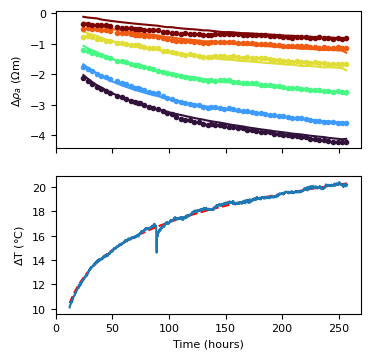

In [31]:
d_256h, J_etrt_256h = simulate_etrt(m_256h[0], m_256h[1], q, m_256h[2], sigma_ref, rBH, times_ert_256h, times_trt_256h, mesh, survey_256h, simulation_256h, getJ=True, sigma_water=np.r_[sigma_w0, ERT_keep['sigmaw']], thermal_model='ICS', type='diff')

stats_256h = misfit(d_256h, d_field_256h, len(times_ert_256h)*len(zrec_256h), len(times_trt_256h), Cdi_256h)
plot_misfit(d_256h, d_field_256h, zrec_256h, times_ert_256h, times_trt_256h)

Now the inversion is run using the 72 h dataset. To obtain consistent data between the two durations, we remove the last 4 electrode spacings (1.25 m, 1.5 m, 1.75 m and 2 m).

In [32]:
i_R72h = 13

In [33]:
ERTkeep_72h = ERT_keep[:i_R72h]
times_ert_72h = ERTkeep_72h['time'].values/3600
times_trt_72h = times_trt[:i_T72h]/3600
zrec_72h = zrec[:-4]
print('ERT measurements at :', np.round(times_ert_72h, 2), 'h')
mesh, simulation_72h, survey_72h = ert_setup(zrec_72h, mesh_selection="fast")

# selected field data
dT = T_trt[:i_T72h] - T0
dR = []
for i, t in enumerate(np.unique(ERTkeep_72h['time'])):
    dR.append(field_data[field_data['time (s)'] == t]['avg dRho-a (Ohm-m)'][:-4].values)

d_field_72h = np.r_[np.r_[dR].flatten(), dT]
Cdi_72h = get_Cdi(times_ert_72h, times_trt_72h, zrec_72h)

wrapped_fun = lambda m: fun(m, times_ert_72h, times_trt_72h, np.r_[sigma_w0, ERTkeep_72h['sigmaw']], survey_72h, simulation_72h)
m_72h = bayesian_inversion(wrapped_fun, d_field_72h, m0, Cdi_72h, niter=10,
                           step=0.8, doprint=True)[0]

ERT measurements at : [24.27 28.27 32.27 36.27 40.27 44.27 48.27 54.27 58.27 62.28 66.28 70.28
 72.28] h
iter 0: cost = 1.178965e+04 (data = 1.178965e+04)model_params = [2.82165035 1.5414003  0.03349193]
iter 1: cost = 1.981315e+03 (data = 1.981315e+03)model_params = [2.71002699 2.04343579 0.0353696 ]
iter 2: cost = 1.675844e+03 (data = 1.675844e+03)model_params = [2.67225218 2.27801218 0.03609099]
iter 3: cost = 1.629048e+03 (data = 1.629048e+03)model_params = [2.66117543 2.35019627 0.03630277]
iter 4: cost = 1.625585e+03 (data = 1.625585e+03)model_params = [2.65824484 2.36800991 0.03635674]
iter 5: cost = 1.625416e+03 (data = 1.625416e+03)model_params = [2.65749074 2.37214586 0.03636996]
iter 6: cost = 1.625409e+03 (data = 1.625409e+03)model_params = [2.65729596 2.37310846 0.03637322]
iter 7: cost = 1.625409e+03 (data = 1.625409e+03)model_params = [2.65724623 2.37333338 0.03637401]
iter 8: cost = 1.625409e+03 (data = 1.625409e+03)model_params = [2.65723305 2.37338822 0.03637421]
iter

In [34]:
d_72h, J_etrt_72h = simulate_etrt(m_72h[0], m_72h[1], q, m_72h[2], sigma_ref, rBH, times_ert_72h, times_trt_72h, mesh, survey_72h, simulation_72h, getJ=True, sigma_water=np.r_[sigma_w0, ERTkeep_72h['sigmaw']], thermal_model='ICS', type='diff')

RMSE dRho-a : 0.06 Ohm.m
Average RMSE dRho-a : 3.384 %
RMSE T      : 0.111 °C
Average RMSE T      : 0.794 %
Chi2        : 1625.409
Chi2 TRT    : 1602.98


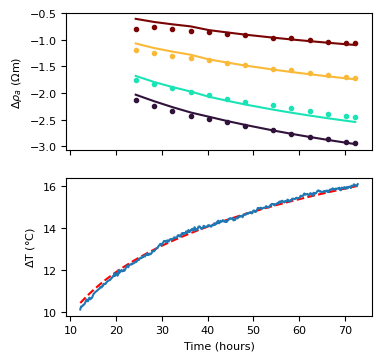

In [35]:
stats_72h = misfit(d_72h, d_field_72h, len(times_ert_72h)*len(zrec_72h), len(times_trt_72h), Cdi_72h)
plot_misfit(d_72h, d_field_72h, zrec_72h, times_ert_72h, times_trt_72h)

The recovered thermal parameters from the E-TRT inversions are

In [36]:
print('Estimated params             k         Cs         m')
print('72 h :              ', m_72h)
print('256 h :             ', m_256h)

Estimated params             k         Cs         m
72 h :               [2.65722731 2.37340871 0.0363743 ]
256 h :              [2.65094066 2.35297548 0.0361244 ]


The recovered thermal parameters from the TRT inversions are

In [37]:
print('Estimated params             k         Cs')
print('72 h :              ', m_est_T72h)
print('256 h :             ', m_est_T256h)

Estimated params             k         Cs
72 h :               [2.42244587 3.21719388]
256 h :              [2.58892982 2.60360164]


The misfit of both datasets is plotted on a single figure.

In [38]:
ERTkeep = pd.concat([ERT_input.iloc[13:][::2][:29], ERT_input.iloc[13:][57:]], ignore_index=True)
dT = T_trt - T0
dR = []
for i, t in enumerate(np.unique(ERTkeep['time'])):
    dR.append(field_data[field_data['time (s)'] == t]['avg dRho-a (Ohm-m)'][:-2].values)

d_field = np.r_[np.r_[dR].flatten(), dT]
      
electrode_spacing = zrec[:-2]
colors = plt.cm.turbo(np.linspace(0, 1, len(electrode_spacing)))
dtime = np.unique(field_data['time (s)'])
ax = ax.flatten()

R_est_256h = d_256h[:len(zrec_256h)*len(times_ert_256h)].reshape((len(times_ert_256h), len(zrec_256h)))
R_est_72h = d_72h[:len(zrec_72h)*len(times_ert_72h)].reshape((len(times_ert_72h), len(zrec_72h)))
R_field = d_field[:len(zrec_256h)*len(ERTkeep['time'])].reshape((len(ERTkeep['time']), len(zrec_256h)))
    
T_est_256h = d_256h[len(zrec_256h)*len(times_ert_256h):]
T_est_72h = d_72h[len(zrec_72h)*len(times_ert_72h):]
T_field = d_field_256h[len(zrec_256h)*len(times_ert_256h):]

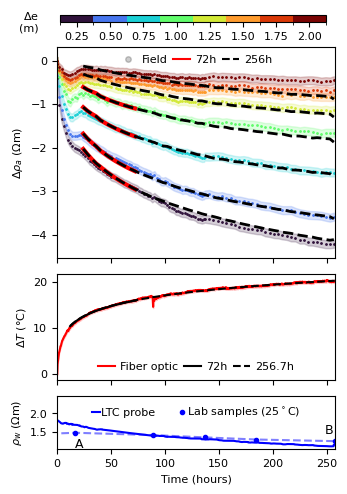

In [39]:
fig, ax = plt.subplots(3, 1, figsize=(9/2.54, 13/2.54), sharex=True, height_ratios=[4, 2, 1])

Ndata = [11, 10, 10, 10, 9, 9, 9, 8]

dtime = np.unique(field_data['time (s)'])/3600
spacing = np.unique(field_data['spacing (m)'])

colors = plt.cm.turbo(np.linspace(0, 1, len(spacing)))
for s, dz in enumerate(spacing):
    subset = field_data[field_data['spacing (m)'] == dz]
    
    ax[0].plot(dtime, subset['avg dRho-a (Ohm-m)'], 'o', color=colors[s], markersize=1)
    ax[0].fill_between(dtime, subset['avg dRho-a (Ohm-m)'] - sigma_ert,subset['avg dRho-a (Ohm-m)'] + sigma_ert,color=colors[s], alpha=0.2)
    
for i in range(len(zrec_72h)):
    ax[0].plot(times_ert_72h, R_est_72h[:, i], '-', color='red', linewidth=3)  
for i in range(len(zrec_256h)):
    ax[0].plot(times_ert_256h, R_est_256h[:, i], '--', color='black', linewidth=2)

ax[1].plot(t_fiber/3600, T_fiber - T0, 'red', label='Fiber optic')
ax[1].fill_between(t_fiber/3600, (T_fiber - T0 - sigma_trt), (T_fiber - T0 + sigma_trt), color='red', alpha=0.2)
ax[1].plot(times_trt_72h,  T_est_72h, 'k-', label='72h')
ax[1].plot(times_trt_256h,  T_est_256h, 'k--', label='256.7h')

ax[0].set_ylabel(r'$\Delta \rho_a$ ($\Omega$m)')
ax[1].set_ylabel('$\Delta T$ (°C)')

ax[2].plot(data_ltc['time (s)']/3600, 1 / data_ltc['sigma_w (S/m)'], label='LTC probe', color='blue')
ax[2].plot(lab_cal['time (s)']/3600, 1 / lab_cal['sigma_w (S/m)'], 'o', label='Lab samples (25$^\circ$C)', color='blue', ms=3)
ax[2].plot(lab_cal['time (s)']/3600, 1 / lab_cal['sigma_w (S/m)'], '--', color='blue', alpha=0.5)
ax[2].text((lab_cal['time (s)'][2]-0.1)/3600, 1 / lab_cal['sigma_w (S/m)'][2] - 0.4, 'A')
ax[2].text((lab_cal['time (s)'][6])/3600-10, 1 / lab_cal['sigma_w (S/m)'][6] + 0.2, 'B')
ax[2].set_ylabel(r'$\rho_w$ ($\Omega$m)')
ax[2].set_xlabel('Time (hours)')
ax[2].legend(loc='upper center', fontsize=8, frameon=False, ncol=2, handlelength=0.7, handletextpad=0.1, labelspacing=0.1)

for a in ax:
    a.set_xlim(0, 258)
    a.tick_params(axis='both', which='major')
    
fitted_handle, = ax[0].plot([], [], 'o', color='black', label='Field', ms=4, alpha=0.2)
field_handle, = ax[0].plot([], [], '-', color='red', label='72h')      
field_handle, = ax[0].plot([], [], '--', color='black', label='256h')

ax[0].legend(fontsize=8, ncol=3, loc='upper center', frameon=False, handlelength=1.5, handletextpad=0.5, borderpad=0.2, columnspacing=0.5)
ax[1].legend(fontsize=8, ncol=3, loc='lower center', frameon=False, handlelength=1.5, handletextpad=0.5, borderpad=0.2, columnspacing=0.5)

plt.tight_layout()

fig.subplots_adjust(top=0.88)

cmap = mcolors.ListedColormap(colors)
bounds = np.append(spacing - 0.125, spacing[-1] + 0.125)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.18, 0.93, 0.75, 0.012])
cb = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', ticks=spacing)
fig.text(0.12, 0.93, '$\Delta$e \n(m)', va='center', ha='right', fontsize=8, rotation=0, color='black')

plt.show()

# 3. Confidence intervals

Confidence intervals at the MAP for the TRT and E-TRT inversions are obtained following the method presented in the notebook `ETRT_synthetic_example.ipynb`.

In [40]:
Cm_etrt_72h = np.linalg.inv(J_etrt_72h.T@Cdi_72h@J_etrt_72h)
conf_etrt_72h = 1.96 * np.sqrt(np.diag(Cm_etrt_72h))

print('72H-ETRT                 k         Cs          m')
print('confidence interval', conf_etrt_72h)
print('confidence interval', conf_etrt_72h/m_256h * 100, '%')

Cm_etrt_256h = np.linalg.inv(J_etrt_256h.T@Cdi_256h@J_etrt_256h)
conf_etrt_256h = 1.96 * np.sqrt(np.diag(Cm_etrt_256h))

print('256H-ETRT                 k         Cs          m')
print('confidence interval', conf_etrt_256h)
print('confidence interval', conf_etrt_256h/m_256h * 100, '%')

72H-ETRT                 k         Cs          m
confidence interval [0.0989822  0.29858731 0.00174343]
confidence interval [ 3.73385188 12.68977552  4.82618826] %
256H-ETRT                 k         Cs          m
confidence interval [0.02457191 0.0897335  0.0004835 ]
confidence interval [0.92691278 3.81361805 1.33843414] %


In [41]:
print('72H-TRT                 k         Cs')
print('confidence interval', conf_trt_72h)
print('confidence interval', conf_trt_72h/m_256h[:-1] * 100)

print('256H-TRT                 k         Cs')
print('confidence interval', conf_trt_256h)
print('confidence interval', conf_trt_256h/m_256h[:-1] * 100)

72H-TRT                 k         Cs
confidence interval [0.17688242 0.73792787]
confidence interval [ 6.67243966 31.36147742]
256H-TRT                 k         Cs
confidence interval [0.06618515 0.27949633]
confidence interval [ 2.49666658 11.878421  ]


The gain of the E-TRT over a standard TRT can be calculated for $k$ and $Cs$

In [42]:
print("Confidence ratio (TRT / ETRT, 72h):", conf_trt_72h / conf_etrt_72h[:-1])
print("Confidence ratio (TRT / ETRT, 256h):", conf_trt_256h / conf_etrt_256h[:-1])

print("Uncertainty reduction (%) with ETRT vs TRT (72h):",
      (conf_trt_72h - conf_etrt_72h[:2]) / conf_trt_72h * 100)

print("Uncertainty reduction (%) with ETRT vs TRT (256h):",
      (conf_trt_256h - conf_etrt_256h[:2]) / conf_trt_256h * 100)


Confidence ratio (TRT / ETRT, 72h): [1.78701241 2.47139734]
Confidence ratio (TRT / ETRT, 256h): [2.69352913 3.11473799]
Uncertainty reduction (%) with ETRT vs TRT (72h): [44.04067968 59.53706085]
Uncertainty reduction (%) with ETRT vs TRT (256h): [62.87398614 67.89457078]


# 3.Grid search

In this section, we run the grid search of the cost function around the solution to evaluate graphically the 95 % confidence region, as described in the notebook `ETRT_synthetic_example.ipynb`.

To speed up computation time we use a limited temporal samples for the ERT data.

In [43]:
ERT_keep_g = pd.concat([ERT_keep[::3], ERT_keep.iloc[-1:]], ignore_index=True)

print('ERT data used for grid search:', np.round(ERT_keep_g['time'].values/3600, 2))

ERT data used for grid search: [ 24.27  36.27  48.27  62.28  72.28  82.28  94.28 106.28 118.28 130.28
 141.03 153.03 165.03 177.03 189.03 201.03 213.03 225.03 237.03 249.03
 256.68]


We run the grid search for these combinations of parameters. 

In [44]:
kg = np.linspace(2.25, 3, 31)
Cg = np.linspace(1.75, 3.5, 36)
mg = np.linspace(0.0331, 0.0395, 33)

Running the grid search is computationnaly expensive. To avoid re-running it each time, we saved the results in the folder `03-Grid_search/03-Field_grid` and load them.

In [ ]:
def run_grid_search(use_Saved_files=True):
    
    dir_grid = "../data/02-Varennes_data/02-Grid_search/"
    if use_Saved_files:
        
        data = []
        
        for m in mg:
            fname = f"gridf_m{m:.4f}.npy"
            fullpath = os.path.join(dir_grid, fname)
            arr = np.load(fullpath)
            data.append(arr)
            
        return data
    
    print('Warning ! Running grid search')
    
    data = []
    for mm in mg:
        dm = []
        for cc in Cg:
            for kk in kg:
                d = simulate_etrt(kk, cc, q, mm, sigma_ref, rBH,
                                  ERT_keep_g['time']/3600, times_trt, mesh, survey, simulation,
                                  getJ=False,
                                  sigma_water=np.r_[sigma_w0, ERT_keep_g['sigmaw']],
                                  thermal_model='ICS', type='abs').ravel()
                dm.append(d)
                
        dm = np.array(dm)
        
        fname = f"grid_m{mm:.5f}.npy"
        np.save(os.path.join(dir_grid, fname), dm)

        data.append(dm)

    return data

dsynt = run_grid_search()

The grid search data is formated.

In [46]:
# Select field data

diffR_field = []
for i, t in enumerate(ERT_keep['time']):
    diffR_field.append(field_data[field_data['time (s)'] == t]['avg dRho-a (Ohm-m)'].values)

diffR_field_72 = []
for i, t in enumerate(ERT_keep['time'][:i_R72h]):
    diffR_field_72.append(field_data[field_data['time (s)'] == t]['avg dRho-a (Ohm-m)'].values)
    
diffR_field = np.array(diffR_field).flatten()
diffR_field_72 = np.array(diffR_field_72).flatten()

diffT_field = T_trt - T0
diffT_field_72 = T_trt[:i_T72h] - T0

In [47]:
# extract the data

nR = (len(ERT_keep_g)+1) * len(zrec)
ndR = (len(ERT_keep_g) ) * len(zrec)
nRi = (len(ERT_keep['time'])+1) * len(zrec)
ndRi = (len(ERT_keep['time'])) * len(zrec)

# Electrical data
diffR = []     
diffR_72h = []

# Temperature data
diffT = []  
diffT_72h = []

for i in range(len(dsynt)):
    
    dR_256h = np.zeros((dsynt[0].shape[0], ndRi))
    dR_72h = np.zeros((dsynt[0].shape[0], i_R72h * len(zrec)))
    dT_256h = np.zeros((dsynt[0].shape[0], len(times_trt)))
    dT_72h = np.zeros((dsynt[0].shape[0], i_T72h))
    
    for j in range(len(dsynt[i])):
        
        d = dsynt[i][j]
    
        Rj = d[:nR].reshape((len(ERT_keep_g)+1, len(zrec)))
        dR = Rj[1:] - Rj[0]
        dR_i = np.array([np.interp(ERT_keep['time'], ERT_keep_g['time'].values, dR[:, j], left=np.nan, right=np.nan)
                          for j in range(dR.shape[1])]).T
        dR_i72h = np.array([np.interp(ERT_keep['time'][:i_R72h], ERT_keep_g['time'].values, dR[:, j], left=np.nan, right=np.nan)
                          for j in range(dR.shape[1])]).T
        
        dT = d[nR:]
        T = dT + T0
        
        dR_256h[j] = dR_i.flatten()
        dR_72h[j] = dR_i72h.flatten()
        dT_256h[j] = dT
        dT_72h[j] = dT[:i_T72h]
        
    diffR.append(dR_256h)
    diffR_72h.append(dR_72h)
    diffT.append(dT_256h)
    diffT_72h.append(dT_72h)

The misfit is calculated for every parameter combination for both duration.

In [48]:
def cost_rmse(length_72h=False):
        
    phi = {'chi2' : [], 'chi2_T' : [], 'chi2_R' :[], 'p(m|dR,dT)':[], 'p(m|dT)':[]}

    if length_72h:
        dR = np.array(diffR_72h)
        dR_f = np.array(diffR_field_72)
        dT = diffT_72h
        dT_f = diffT_field_72
        tR = ERT_keep['time'][:i_R72h]
        tT = times_trt[:i_T72h]
       
        de = zrec[:-4]
        mask = np.mod(np.arange(len(dR_f)), 8) < 4
        cov = get_Cdi(tR/3600, tT/3600, de)
        nR = len(tR) * len(de)
        covR = cov[:nR, :nR]
        covT = cov[nR:, nR:]
        
    else :
        dR = np.array(diffR)
        dR_f = np.array(diffR_field)
        dT = diffT
        dT_f = diffT_field
        tR = ERT_keep['time']
        tT = times_trt
        
        de = zrec[:-2]
        mask = np.mod(np.arange(len(dR_f)), 8) < 6
        cov = get_Cdi(tR/3600, tT/3600, de)
        nR = len(tR) * len(de)
        covR = cov[:nR, :nR]
        covT = cov[nR:, nR:]
        
    
    for i in range(len(dsynt)):

        d = np.concatenate((dR_f[mask].T, dT_f.T))
        dmod= np.concatenate((dR[i][:,mask].T, dT[i].T))
        r = dmod - d.T[:, np.newaxis]
        rT = dT[i].T - dT_f[:, np.newaxis]
        rR = dmod[:nR] - d[:nR].T[:, np.newaxis]
                
        phi['chi2'].append(np.einsum('ij,ij->j', r, cov @ r).reshape(len(Cg), len(kg)))
        phi['chi2_T'].append(np.einsum('ij,ij->j', rT, covT @ rT).reshape(len(Cg), len(kg)))
        phi['chi2_R'].append(np.einsum('ij,ij->j', rR, covR @ rR).reshape(len(Cg), len(kg)))
        
    # Compute global minima across all slices
    all_chi2 = np.stack(phi['chi2'], axis=0)
    global_min_chi2 = np.min(all_chi2)
    
    all_chi2T = np.stack(phi['chi2_T'], axis=0)
    global_min_chi2T = np.min(all_chi2T)
    
    phi['p(m|dR,dT)'] = []
    phi['p(m|dT)'] = []

    for chi2_vals in phi['chi2']:
        chi2_shifted = chi2_vals - global_min_chi2
        likelihood = np.exp(-0.5 * chi2_shifted)
        phi['p(m|dR,dT)'].append(likelihood)
    
    for chi2T_vals in phi['chi2_T']:
        chi2T_shifted = chi2T_vals - global_min_chi2T
        likelihoodT = np.exp(-0.5 * chi2T_shifted)
        sT = likelihoodT.sum()
        phi['p(m|dT)'].append(likelihoodT / sT if sT > 0 and np.isfinite(sT) else np.zeros_like(likelihoodT))

    
    cube = np.stack(phi['p(m|dR,dT)'], axis=0)
    cube /= cube.sum()
    phi['p(m|dR,dT)'] = [cube[i] for i in range(cube.shape[0])]
    phi['p(m|dT)'] = [p / np.sum(p) for p in phi['p(m|dT)']]
        
    return phi


In [49]:
phi_field_256h = cost_rmse()
phi_field_72 = cost_rmse(length_72h=True)

## Plot the misfit

As in the notebook `ETRT_synthetic_example.ipynb`, we can plot the misfit and the 95 % confidence regions. We only plot the results for the 72h dataset as the MAP confidence intervals for the 256h dataset fall near the resolution of the grid.

In [50]:
from etrt.grid_fun import plot_sum_across_slices
from scipy.stats import chi2
import matplotlib.lines as mlines
import matplotlib.ticker as mticker

In [51]:
def covariance_ellipse(Cm, center, ax=None, style='--w'):
    from scipy.stats import chi2
    theta = np.arange(0, 2*np.pi, 0.01).reshape(1, -1)
    delta = np.sqrt(chi2.ppf(0.95, 2))
    lam, u =np.linalg.eig(np.linalg.inv(Cm))
    r=delta/np.sqrt(lam) #the radii for each ellipsoid
    e=r[0]*u[:,:1]@np.cos(theta)+r[1]*u[:,1:]@np.sin(theta) #compute the ellipsoids
    e=e+np.array([center[0], center[1]]).reshape(-1, 1)
    if ax:
        ax.plot(e[0,:], e[1,:], style, alpha=0.7)
    else :
        plt.plot(e[0,:], e[1,:],style, alpha=0.7)

/tmp/ipykernel_26683/1335786995.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.4, hspace=0.4, bottom=0.15)
/userdata/u/cszabosom/project/01 - Main script/03 - Varennes/05-clean_versions/grid_fun.py:60: UserWarning: The following kwargs were not used by contour: 'interpolation'
  cf = ax.contourf(X, Y, data,


(2.25, 3.0)

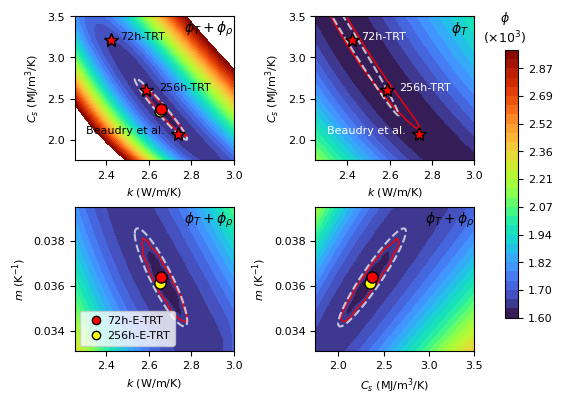

In [52]:
vmin = np.min(np.min(np.array(phi_field_72['chi2_T']), axis=0))
vmax = np.max(np.max(np.array(phi_field_72['chi2']), axis=0))
vmax = 2e4

fig, ax = plt.subplots(2, 2, figsize=(14/2.54, 10/2.54), constrained_layout=True)
plt.subplots_adjust(wspace=0.4, hspace=0.4, bottom=0.15)
ax = ax.flatten()

planes = ['Ck', 'Ck_T', 'km', 'Cm']
for idx in [0, 2, 3]:
    cf = plot_sum_across_slices(ax[idx], phi_field_72,
                                Rtype='chi2', Ttype='chi2_T',
                                kk=kg, CC=Cg, mm=mg, iso_levels=[chi2.ppf(0.95, 3)+stats_72h[2]],
                                plane=planes[idx], vmin=vmin, vmax=3e3, sumcost=False, log=True, iso_style='-')

cft = plot_sum_across_slices(ax[1], phi_field_72,
                               Rtype='chi2', Ttype='chi2_T',
                               kk=kg, CC=Cg, mm=mg, iso_levels=[chi2.ppf(0.95, 2)+stats_72h[3]],
                               plane=planes[1], vmin=np.min(np.min(np.array(phi_field_72['chi2_T']), axis=0)), vmax=vmax, sumcost=False, log=True, iso_style='-')

# Add MAP covariance ellipses
covariance_ellipse(Cm_etrt_72h[:2, :2], [m_72h[0], m_72h[1]], ax=ax[0], style='--w')
covariance_ellipse(Cm_etrt_72h[[0,2]][:,[0,2]], [m_72h[0], m_72h[2]], ax=ax[2], style='--w')
covariance_ellipse(Cm_etrt_72h[[1,2]][:,[1,2]], [m_72h[1], m_72h[2]], ax=ax[3], style='--w')
covariance_ellipse(Cm_trt_72h, m_trt[0], ax=ax[1], style='--w')

ax[0].set_xlabel('$k$ (W/m/K)')
ax[0].set_ylabel('$C_s$ (MJ/m$^3$/K)')
ax[1].set_xlabel('$k$ (W/m/K)')
ax[1].set_ylabel('$C_s$ (MJ/m$^3$/K)')
ax[2].set_xlabel('$k$ (W/m/K)')
ax[2].set_ylabel('$m$ (K$^{-1}$)')
ax[3].set_xlabel('$C_s$ (MJ/m$^3$/K)')
ax[3].set_ylabel('$m$ (K$^{-1}$)')

# Add points on the grid

ax[0].plot(m_256h[0], m_256h[1], marker='o', markersize=8, color='k', label='All-E-TRT', markerfacecolor='yellow')
ax[2].plot(m_256h[0], m_256h[2], marker='o', markersize=8, color='k', markerfacecolor='yellow')
ax[3].plot(m_256h[1], m_256h[2], marker='o', markersize=8, color='k', markerfacecolor='yellow')

ax[0].plot(m_72h[0], m_72h[1], marker='o', markersize=8, color='k', markerfacecolor='red', label='72h-E-TRT')
ax[2].plot(m_72h[0], m_72h[2], marker='o', markersize=8, color='k', markerfacecolor='red')
ax[3].plot(m_72h[1], m_72h[2], marker='o', markersize=8, color='k', markerfacecolor='red')

# Create legend and labels

marker_256h = mlines.Line2D([], [], color='k', marker='o', linestyle='None', markersize=6, label='256h-E-TRT',markerfacecolor='yellow')
marker_72h = mlines.Line2D([], [], color='k', marker='o', linestyle='None', markersize=6, markerfacecolor='red', label='72h-E-TRT')
ax[2].legend(handles=[marker_72h, marker_256h], loc='lower left', handletextpad=0.05, fontsize=8, framealpha=0.8)

label = ['72h-TRT', '256h-TRT', 'Beaudry et al.']
move = [-0.15, -0.18, 0.25]
for i, mm in enumerate(m_trt):
    ax[1].plot(mm[0], mm[1], marker='*', markersize=10, color='k', markerfacecolor='red')
    ax[0].plot(mm[0], mm[1], marker='*', markersize=10, color='k', markerfacecolor='red')
    ax[1].text(mm[0]-move[i], mm[1], label[i], color='white', fontsize=8, ha='center')
    ax[0].text(mm[0]-move[i], mm[1], label[i], color='black', fontsize=8, ha='center')
    
ax[0].text(0.69, 0.98, "$\\phi_T + \\phi_\\rho$", color='black',transform=ax[0].transAxes, weight='bold', va='top', fontsize=10)
ax[1].text(0.85, 0.98, "$\\phi_T$", color='black',transform=ax[1].transAxes, weight='bold', va='top', fontsize=10)
ax[2].text(0.69, 0.98,  "$\\phi_T + \\phi_\\rho$", color='black',transform=ax[2].transAxes, weight='bold', va='top', fontsize=10)
ax[3].text(0.69, 0.98,  "$\\phi_T + \\phi_\\rho$", color='black',transform=ax[3].transAxes, weight='bold', va='top', fontsize=10)

# Add colorbar

cbar1 = fig.colorbar(cf, ax=[ax[0], ax[2], ax[3]], location='right', shrink=0.8, pad=0.0, orientation='vertical')
cbar1.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e3:.2f}"))
cbar1.ax.tick_params(labelsize=8)
cbar1.ax.text(0, 1.15, "$\\phi$\n$(\\times 10^3)$", va='top', ha='center', transform=cbar1.ax.transAxes)

ax[1].set_ylim(Cg[0], 3.5)
ax[1].set_xlim(kg[0], kg[-1])

## Plot marginals

As described in the notebook `ETRT_synthetic_example.ipynb`, we can obtain the posterior distribution from the grid search allowing to compute the MAP, mean, marginals, and confidence intervals. The marginals are plotted in all parameters planes.

In [53]:
from etrt.grid_fun import plot_prob
from matplotlib import patches

We start with the 72 hour dataset

/tmp/ipykernel_26683/3055181524.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.4, hspace=0.4, bottom=0.15)
/userdata/u/cszabosom/project/01 - Main script/03 - Varennes/05-clean_versions/grid_fun.py:166: UserWarning: Log scale: values of z <= 0 have been masked
  cf = ax.contourf(X, Y, data, levels=levels, cmap=cmap, norm=norm)


Text(0, 1.1, '$p(m_1, m_2|d)$')

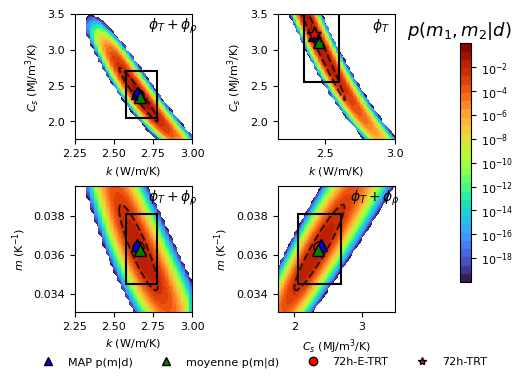

In [54]:
fig, ax = plt.subplots(2, 2, figsize=(13/2.54, 9/2.54), constrained_layout=True)
plt.subplots_adjust(wspace=0.4, hspace=0.4, bottom=0.15)

ax = ax.flatten()

ax[0].plot(m_72h[0], m_72h[1], marker='o', markersize=8, color='k', markerfacecolor='red', label='72h-E-TRT')
ax[2].plot(m_72h[0], m_72h[2], marker='o', markersize=8, color='k', markerfacecolor='red')
ax[3].plot(m_72h[1], m_72h[2], marker='o', markersize=8, color='k', markerfacecolor='red')

pmd_72h = {}
for idx, a in enumerate(ax.flatten()):
    cf, pmd_72h = plot_prob(
        a, phi_field_72,
        Rtype='p(m|dR,dT)', Ttype='p(m|dT)',
        kk=kg, CC=Cg, mm=mg,
        plane=planes[idx],
        vmin=1e-20, vmax=1.0,
        iso_levels=[],
        #sumcost=False,
        #log=True
    )
    if planes[idx] == "Ck_T":
        stats = pmd_72h["TRT"]
    else:
        stats = pmd_72h["E-TRT"]   

    ci = stats["confidence_intervals"]
    MAP = stats["MAP"]
    mean = stats["mean"]

    # Confidence interval rectangle
    if planes[idx] == "Ck":
        xlow, xhigh = ci["k"]; ylow, yhigh = ci["C"]
        a.add_patch(patches.Rectangle((xlow, ylow), xhigh-xlow, yhigh-ylow,
                                      linewidth=1.5, edgecolor='black', facecolor='none', linestyle='-'))
        a.plot(MAP[1], MAP[0], marker='^', color='k', label='MAP', markerfacecolor='blue')
        a.plot(mean[1], mean[0], marker='^', color='k', label='Mean', markerfacecolor='green')

    elif planes[idx] == "Ck_T":
        xlow, xhigh = ci["k"]; ylow, yhigh = ci["C"]
        a.add_patch(patches.Rectangle((xlow, ylow), xhigh-xlow, yhigh-ylow,
                                      linewidth=1.5, edgecolor='black', facecolor='none', linestyle='-'))
        a.plot(MAP[1], MAP[0], marker='^', color='k', label='MAP', markerfacecolor='blue')
        a.plot(mean[1], mean[0], marker='^', color='k', label='Mean', markerfacecolor='green')

    elif planes[idx] == "km":
        xlow, xhigh = ci["k"]; ylow, yhigh = ci["m"]
        a.add_patch(patches.Rectangle((xlow, ylow), xhigh-xlow, yhigh-ylow,
                                      linewidth=1.5, edgecolor='black', facecolor='none', linestyle='-'))
        a.plot(MAP[1], MAP[2], marker='^', color='k', label='MAP', markerfacecolor='blue')
        a.plot(mean[1], mean[2], marker='^', color='k', label='Mean', markerfacecolor='green')

    elif planes[idx] == "Cm":
        xlow, xhigh = ci["C"]; ylow, yhigh = ci["m"]
        a.add_patch(patches.Rectangle((xlow, ylow), xhigh-xlow, yhigh-ylow,
                                      linewidth=1.5, edgecolor='black', facecolor='none', linestyle='-'))
        a.plot(MAP[0], MAP[2], marker='^', color='k', label='MAP', markerfacecolor='blue')
        a.plot(mean[0], mean[2], marker='^', color='k', label='Mean', markerfacecolor='green')

# axis labels as before
ax[0].set_xlabel('$k$ (W/m/K)')
ax[0].set_ylabel('$C_s$ (MJ/m$^3$/K)')
ax[1].set_xlabel('$k$ (W/m/K)')
ax[1].set_ylabel('$C_s$ (MJ/m$^3$/K)')
ax[2].set_xlabel('$k$ (W/m/K)')
ax[2].set_ylabel('$m$ (K$^{-1}$)')
ax[3].set_xlabel('$C_s$ (MJ/m$^3$/K)')
ax[3].set_ylabel('$m$ (K$^{-1}$)')
ax[1].set_ylim(1.75, 3.5)

covariance_ellipse(Cm_etrt_72h[:2, :2], [m_72h[0], m_72h[1]], ax=ax[0], style='--k')
covariance_ellipse(Cm_etrt_72h[[0,2]][:,[0,2]], [m_72h[0], m_72h[2]], ax=ax[2], style='--k')
covariance_ellipse(Cm_etrt_72h[[1,2]][:,[1,2]], [m_72h[1], m_72h[2]], ax=ax[3], style='--k')
covariance_ellipse(Cm_trt_72h, m_trt[0], ax=ax[1], style='--k')
    
ax[1].plot(m_trt[0][0], m_trt[0][1], marker='*', markersize=10, color='k', markerfacecolor='red')

# legend
marker_MAP = mlines.Line2D([], [], color='k', marker='^', linestyle='None', markersize=6, markerfacecolor='blue', label='MAP p(m|d)')
marker_MEAN = mlines.Line2D([], [], color='k', marker='^', linestyle='None',markersize=6, markerfacecolor='green', label='moyenne p(m|d)')
marker_INV = mlines.Line2D([], [], color='k', marker='o', linestyle='None',markersize=6, markerfacecolor='red', label='72h-E-TRT')
marker_INVT = mlines.Line2D([], [], color='k', marker='*', linestyle='None',markersize=6, markerfacecolor='red', label='72h-TRT')
#ax[1].legend(handles=[marker_MAP, marker_MEAN, marker_INV], loc='lower left', handletextpad=0.05, fontsize=8, framealpha=0.4)

fig.legend(handles=[marker_MAP, marker_MEAN, marker_INV, marker_INVT],
           loc='lower center', bbox_to_anchor=(0.5, -0.05),
           ncol=4, fontsize=8, framealpha=0)

ax[0].text(0.62, 0.98, "$\\phi_T + \\phi_\\rho$", color='black',transform=ax[0].transAxes, weight='bold', va='top', fontsize=10)
ax[1].text(0.80, 0.98, "$\\phi_T$", color='black',transform=ax[1].transAxes, weight='bold', va='top', fontsize=10)
ax[2].text(0.62, 0.98,  "$\\phi_T + \\phi_\\rho$", color='black',transform=ax[2].transAxes, weight='bold', va='top', fontsize=10)
ax[3].text(0.62, 0.98,  "$\\phi_T + \\phi_\\rho$", color='black',transform=ax[3].transAxes, weight='bold', va='top', fontsize=10)


# colorbar
cbar = fig.colorbar(cf, ax=ax, location='right', shrink=0.8, pad=0.01, orientation='vertical', ticks=[1e-18,1e-16,1e-14,1e-12, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2])
cbar.ax.text(0, 1.1, '$p(m_1, m_2|d)$', va='top', ha='center', transform=cbar.ax.transAxes, fontsize=13)

In [55]:
for name, stats in pmd_72h.items():
    print(f"\nResults for {name}:")
    print("  MAP estimate:", np.round(stats["MAP"], 5))
    print("  Posterior mean:", np.round(stats["mean"], 5))
    print("  Confidence intervals:")
    for param, ci in stats["confidence_intervals"].items():
        low, high = ci 
        half_width = (high - low) / 2 
        print(f"{param:<10} : [{low:.5f}, {high:.5f}] (±{half_width:.5f})")


Results for E-TRT:
  MAP estimate: [2.4    2.65   0.0365]
  Posterior mean: [2.34615 2.66917 0.03623]
  Confidence intervals:
C          : [2.05000, 2.70000] (±0.32500)
k          : [2.57500, 2.77500] (±0.10000)
m          : [0.03450, 0.03810] (±0.00180)

Results for TRT:
  MAP estimate: [3.2   2.425]
  Posterior mean: [3.10306 2.45401]
  Confidence intervals:
C          : [2.55000, 3.50000] (±0.47500)
k          : [2.35000, 2.60000] (±0.12500)


In [56]:
print("\nComparison with MAP confidence intervals")

param_names = ["k", "C", "m"]

print("E-TRT:")
for name, val in zip(param_names, conf_etrt_72h):
    print(f"    {name}: {val:.5f}")
    
print("TRT:")
for name, val in zip(param_names, conf_trt_72h):
    print(f"    {name}: {val:.5f}")



Comparison with MAP confidence intervals
E-TRT:
    k: 0.09898
    C: 0.29859
    m: 0.00174
TRT:
    k: 0.17688
    C: 0.73793


And now the full 256 hour dataset

/tmp/ipykernel_26683/2560922748.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.4, hspace=0.4, bottom=0.15)


Text(0, 1.1, '$p(m_1, m_2|d)$')

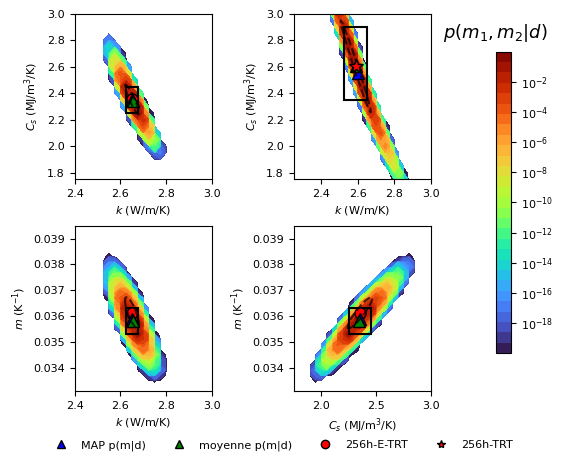

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(14/2.54, 11/2.54), constrained_layout=True)
plt.subplots_adjust(wspace=0.4, hspace=0.4, bottom=0.15)

planes = ['Ck', 'Ck_T', 'km', 'Cm']
pmd_256h = {}

ax = ax.flatten()

ax[0].plot(m_256h[0], m_256h[1], marker='o', markersize=8, color='k', markerfacecolor='red')
ax[2].plot(m_256h[0], m_256h[2], marker='o', markersize=8, color='k', markerfacecolor='red')
ax[3].plot(m_256h[1], m_256h[2], marker='o', markersize=8, color='k', markerfacecolor='red')

for idx, a in enumerate(ax.flatten()):
    cf, pmd_256h = plot_prob(
        a, phi_field_256h,
        Rtype='p(m|dR,dT)', Ttype='p(m|dT)',
        kk=kg, CC=Cg, mm=mg,
        plane=planes[idx],
        vmin=1e-20, vmax=1.0,
        iso_levels=[],
    )
    if planes[idx] == "Ck_T":
        stats = pmd_256h["TRT"]
    else:
        stats = pmd_256h["E-TRT"]   

    ci = stats["confidence_intervals"]
    MAP = stats["MAP"]
    mean = stats["mean"]

    # --- overlay confidence interval rectangle ---
    if planes[idx] == "Ck":
        xlow, xhigh = ci["k"]; ylow, yhigh = ci["C"]
        a.add_patch(patches.Rectangle((xlow, ylow), xhigh-xlow, yhigh-ylow,
                                      linewidth=1.5, edgecolor='black', facecolor='none', linestyle='-'))
        a.plot(MAP[1], MAP[0], marker='^', color='k', label='MAP', markerfacecolor='blue')
        a.plot(mean[1], mean[0], marker='^', color='k', label='Mean', markerfacecolor='green')

    elif planes[idx] == "Ck_T":
        xlow, xhigh = ci["k"]; ylow, yhigh = ci["C"]
        a.add_patch(patches.Rectangle((xlow, ylow), xhigh-xlow, yhigh-ylow,
                                      linewidth=1.5, edgecolor='black', facecolor='none', linestyle='-'))
        a.plot(MAP[1], MAP[0], marker='^', color='k', label='MAP', markerfacecolor='blue')
        a.plot(mean[1], mean[0], marker='^', color='k', label='Mean', markerfacecolor='green')

    elif planes[idx] == "km":
        xlow, xhigh = ci["k"]; ylow, yhigh = ci["m"]
        a.add_patch(patches.Rectangle((xlow, ylow), xhigh-xlow, yhigh-ylow,
                                      linewidth=1.5, edgecolor='black', facecolor='none', linestyle='-'))
        a.plot(MAP[1], MAP[2], marker='^', color='k', label='MAP', markerfacecolor='blue')
        a.plot(mean[1], mean[2], marker='^', color='k', label='Mean', markerfacecolor='green')

    elif planes[idx] == "Cm":
        xlow, xhigh = ci["C"]; ylow, yhigh = ci["m"]
        a.add_patch(patches.Rectangle((xlow, ylow), xhigh-xlow, yhigh-ylow,
                                      linewidth=1.5, edgecolor='black', facecolor='none', linestyle='-'))
        a.plot(MAP[0], MAP[2], marker='^', color='k', label='MAP', markerfacecolor='blue')
        a.plot(mean[0], mean[2], marker='^', color='k', label='Mean', markerfacecolor='green')

ax = ax.flatten()
# axis labels as before
ax[0].set_xlabel('$k$ (W/m/K)')
ax[0].set_ylabel('$C_s$ (MJ/m$^3$/K)')
ax[1].set_xlabel('$k$ (W/m/K)')
ax[1].set_ylabel('$C_s$ (MJ/m$^3$/K)')
ax[2].set_xlabel('$k$ (W/m/K)')
ax[2].set_ylabel('$m$ (K$^{-1}$)')
ax[3].set_xlabel('$C_s$ (MJ/m$^3$/K)')
ax[3].set_ylabel('$m$ (K$^{-1}$)')

ax[0].set_ylim(1.75, 3)
ax[1].set_ylim(1.75, 3)
ax[0].set_xlim(2.4, 3)
ax[2].set_xlim(2.4, 3)
ax[3].set_xlim(1.75, 3)

k, C, m = m_256h
covariance_ellipse(Cm_etrt_256h[:2, :2], [k, C], ax=ax[0], style='--k')
covariance_ellipse(Cm_etrt_256h[[0,2]][:,[0,2]], [k, m], ax=ax[2], style='--k')
covariance_ellipse(Cm_etrt_256h[[1,2]][:,[1,2]], [C, m], ax=ax[3], style='--k')
covariance_ellipse(Cm_trt_256h, m_trt[1], ax=ax[1], style='--k')
ax[1].plot(m_trt[1][0], m_trt[1][1], marker='*', markersize=10, color='k', markerfacecolor='red')


marker_INV = mlines.Line2D([], [], color='k', marker='o', linestyle='None',markersize=6, markerfacecolor='red', label='256h-E-TRT')
marker_INVT = mlines.Line2D([], [], color='k', marker='*', linestyle='None',markersize=6, markerfacecolor='red', label='256h-TRT')
fig.legend(handles=[marker_MAP, marker_MEAN, marker_INV, marker_INVT],
           loc='lower center', bbox_to_anchor=(0.5, -0.05),
           ncol=4, fontsize=8, framealpha=0)

# colorbar
cbar = fig.colorbar(cf, ax=ax, location='right', shrink=0.8, pad=0.01,
                    orientation='vertical', ticks=[1e-18, 1e-16, 1e-14,  1e-12, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2])
cbar.ax.text(0, 1.1, '$p(m_1, m_2|d)$', va='top', ha='center',
             transform=cbar.ax.transAxes, fontsize=13)

In [58]:
for name, stats in pmd_256h.items():
    print(f"\nResults for {name}:")
    print("  MAP estimate:", np.round(stats["MAP"], 5))
    print("  Posterior mean:", np.round(stats["mean"], 5))
    print("  Confidence intervals:")
    for param, ci in stats["confidence_intervals"].items():
        low, high = ci 
        half_width = (high - low) / 2 
        print(f"{param:<10} : [{low:.5f}, {high:.5f}] (±{half_width:.5f})")


Results for E-TRT:
  MAP estimate: [2.35   2.65   0.0359]
  Posterior mean: [2.34298 2.65349 0.0358 ]
  Confidence intervals:
C          : [2.25000, 2.45000] (±0.10000)
k          : [2.62500, 2.67500] (±0.02500)
m          : [0.03530, 0.03630] (±0.00050)

Results for TRT:
  MAP estimate: [2.55 2.6 ]
  Posterior mean: [2.60686 2.5892 ]
  Confidence intervals:
C          : [2.35000, 2.90000] (±0.27500)
k          : [2.52500, 2.65000] (±0.06250)


In [59]:
print("\nComparison with MAP confidence intervals")

param_names = ["k", "C", "m"]

print("E-TRT:")
for name, val in zip(param_names, conf_etrt_256h):
    print(f"    {name}: {val:.5f}")
    
print("TRT:")
for name, val in zip(param_names, conf_trt_256h):
    print(f"    {name}: {val:.5f}")



Comparison with MAP confidence intervals
E-TRT:
    k: 0.02457
    C: 0.08973
    m: 0.00048
TRT:
    k: 0.06619
    C: 0.27950


Some conclusions
- The MAP and mean estimates are close to the MAP obtained by inversion, and the divergence may be explained by the resolution of the grid
- The E-TRT confidence intervals obtained from the posterior are close to those obtained from the MAP, confirming the validity of the linear approximation
- The TRT confidence intervals obtained from the posterior greatly underestimate those obtained from the MAP. This is because by normalizing the sum over the grid to 1, we implicitly assume a uniform prior over the grid.